## Importing Libraries

In [16]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics.pairwise as pw
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
books=pd.read_csv('/content/book.csv') # An encoding error occurs because utf-8 cannot decode some bytes
books

UnicodeDecodeError: ignored

In [3]:
books=pd.read_csv('/content/book.csv',encoding='Latin1') # The solution was change the encoding to latin-1
books

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6
...,...,...,...,...
9995,9996,162121,American Fried: Adventures of a Happy Eater.,7
9996,9997,162121,Cannibal In Manhattan,9
9997,9998,162121,How to Flirt: A Practical Guide,7
9998,9999,162121,Twilight,8


In [5]:
books.rename(columns={'Unnamed: 0':'ID'}, inplace=True )
books.rename(columns={'Book.Title':'Title'}, inplace = True)
books.rename(columns={'User.ID':'User'}, inplace = True)
books.rename(columns={'Book.Rating':'Rating'}, inplace = True)
books

,ID,User,Title,Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6
...,...,...,...,...
9995,9996,162121,American Fried: Adventures of a Happy Eater.,7
9996,9997,162121,Cannibal In Manhattan,9
9997,9998,162121,How to Flirt: A Practical Guide,7
9998,9999,162121,Twilight,8


In [7]:
num_ratings = books['Rating'].count()
num_users = books['ID'].nunique()
num_books = books['Title'].nunique()

pd.DataFrame([['# of Ratings', num_ratings],
            ['# of Users', num_users],
            ['# of Books', num_books]],
            columns = ['Characteristic', 'Count'])

,Characteristic,Count
0,# of Ratings,10000
1,# of Users,10000
2,# of Books,9659


#### As we can see, there were 10000 rows and 4 columns out of which Rating Count is 10000, Unique Users 2182 & Unique Book title is 9659



## Average Ratings by Users


In [8]:
books.describe()

,ID,User,Rating
count,10000.00000,10000.000000,10000.00000
mean,5000.50000,95321.249800,7.56630
std,2886.89568,117645.703609,1.82152
min,1.00000,8.000000,1.00000
25%,2500.75000,2103.000000,7.00000
50%,5000.50000,3757.000000,8.00000
75%,7500.25000,162052.000000,9.00000
max,10000.00000,278854.000000,10.00000


In [9]:
books['Rating'].describe()

count    10000.00000
mean         7.56630
std          1.82152
min          1.00000
25%          7.00000
50%          8.00000
75%          9.00000
max         10.00000
Name: Rating, dtype: float64

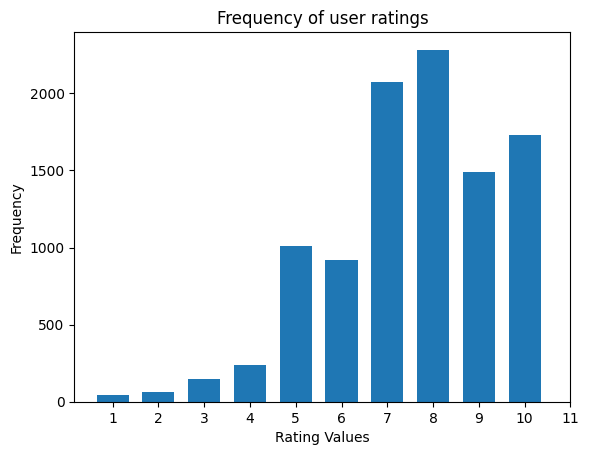

In [13]:
data = books['Rating']
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

plt.hist(data, bins, align="left", rwidth = 0.7)
plt.xticks(bins)
plt.xlabel('Rating Values')
plt.ylabel('Frequency')
plt.title('Frequency of user ratings')
plt.show()

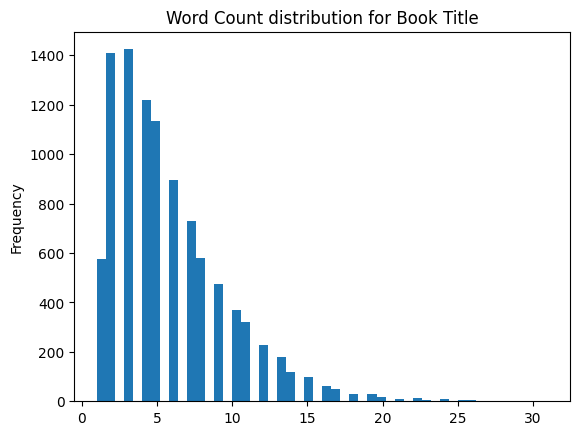

In [14]:
# calculating the word count for book description
books['word_count'] = books['Title'].apply(lambda x: len(str(x).split()))
books['word_count'].plot(kind = 'hist',bins = 50)
plt.title ('Word Count distribution for Book Title')
plt.show()

In [18]:
rating = pd.DataFrame(books, columns=['ID', 'Title', 'Rating'])
print(rating)

         ID                                              Title  Rating
0         1                                Classical Mythology       5
1         2                                       Clara Callan       3
2         3                               Decision in Normandy       6
3         4  Flu: The Story of the Great Influenza Pandemic...       8
4         5                             The Mummies of Urumchi       6
...     ...                                                ...     ...
9995   9996       American Fried: Adventures of a Happy Eater.       7
9996   9997                              Cannibal In Manhattan       9
9997   9998                    How to Flirt: A Practical Guide       7
9998   9999                                           Twilight       8
9999  10000                       Kids Say the Darndest Things       6

[10000 rows x 3 columns]


In [19]:
# We create now a table grouped by user and book pair, calculating mean and number of
# rating that a user has made for the same book

rating['count'] = rating['Rating']

userRatesPerBooks = rating.groupby(['ID', 'Title'], as_index = False) \
                   .agg({'Rating' : 'mean', 'count' : 'count'}) \
                   .rename(columns = {'Rating':'mean'}) \
                   .sort_values('count', ascending = False)

ratings = rating.drop(['count'], axis = 1)

userRatesPerBooks['mean'] = userRatesPerBooks['mean'].round(0)
userRatesPerBooks.head()

,ID,Title,mean,count
0,1,Classical Mythology,5.0,1
6670,6671,At Wits End,1.0,1
6663,6664,Intimate Evil: A Novel,8.0,1
6664,6665,Magic Goes Away,8.0,1
6665,6666,Beloved Exile,8.0,1


In [21]:
# To append the mean and count per each user and book to the ratings table:

ratings = pd.merge(rating, userRatesPerBooks, on = ['ID', 'Title'])
ratings.head()


,ID,Title,Rating,count_x,mean,count_y
0,1,Classical Mythology,5,5,5.0,1
1,2,Clara Callan,3,3,3.0,1
2,3,Decision in Normandy,6,6,6.0,1
3,4,Flu: The Story of the Great Influenza Pandemic...,8,8,8.0,1
4,5,The Mummies of Urumchi,6,6,6.0,1


In [23]:
# Query to drop the duplicates records for the combination user/book with more than 1 rating
ratings = rating.drop_duplicates(subset = ['Title', 'ID'], keep = 'first', inplace = False)\
                                  .sort_values('count', ascending = False)
ratings = rating.drop(['count'], axis = 1)
ratings.head()

,ID,Title,Rating
0,1,Classical Mythology,5
1,2,Clara Callan,3
2,3,Decision in Normandy,6
3,4,Flu: The Story of the Great Influenza Pandemic...,8
4,5,The Mummies of Urumchi,6
